In [1]:
# Need to rebuild CNN with scripts in order to achieve one-liner get_analyzed_plot
#from MyModules.oanda_plot import analyze_plot_oanda

In [2]:
import pandas as pd, numpy as np, datetime as dt
from MyModules.features import new_datetime_alpha, new_datetime_complete
from MyModules.candlePlotting import plot_ticks
import http, json

def get_oanda_candles(instr, period, start):
    conn = http.client.HTTPSConnection("api-fxpractice.oanda.com")
    headers = {"Authorization": "Bearer ***REMOVED***"}
    url = "https://api-fxpractice.oanda.com/v3/instruments/{}/candles?&from={}&granularity={}&alignmentTimezone=America/Los_Angeles"\
            .format(instr, start, period)
    conn.request("GET", url, None, headers)
    resp = conn.getresponse()
    if resp.status in (201, 200):
        return json.loads(resp.read())
    else:
        raise http.client.HTTPException("Error in HTTP request (status: " + str(resp.status) + "):\n" + str(resp.read()))

## This function assumes that delta are from after the 2nd-to-last candle, since last hasn't closed yet
def get_df_deltas(instr, freq, period):
# Get local df dataset
    df = pd.read_csv(r'datasets/{} {}{}.csv'.format(instr, freq, period),
                     parse_dates=[0], index_col=0).sort_index()
    df = df[(df.Open != df.High) & (df.Open != df.Low) & (df.Open != df.Close)]
# Get delta candles from last date of df
    delta_candles = get_oanda_candles('EUR_USD', 'D', df.index[-1].strftime('%Y-%m-%dT%H:%M:%S.000000000Z'))
    delta_candles = pd.DataFrame(delta_candles['candles']).drop(['complete', 'volume'], axis=1)
    delta_candles['time'] = pd.to_datetime(delta_candles['time'])
    delta_candles = delta_candles.set_index('time')

    cols = ('Open', 'High', 'Low', 'Close')
    for c in cols:
        delta_candles[c] = delta_candles['mid'].apply(lambda r: float(r['{}'.format(c[0].lower())]))
    delta_candles = delta_candles.drop('mid', axis=1)
# Drop last point of df assuming it's the same date as the first delta candle    
    if df.index[-1] == delta_candles.index[0]: df = df.drop(df.index[-1])
# Get Rejection price of delta candles (except for current point)
    if len(delta_candles) > 1:
        for n in range(4, 9): df[str(n)] = np.nan
        df = df[['Open', 'High', 'Low', 'Close', '4', '5', '6', '7', '8', 'Rejection']]
        for i in range(len(delta_candles)-1):
            _, df = new_datetime_alpha(df, df, delta_candles.iloc[i])
        df = df.drop([str(n) for n in range(4, 9)], axis=1)
        df = df.append(delta_candles.iloc[-1])
    elif len(delta_candles) == 1:
        delta_candles['Rejection'] = np.nan
        df = df.append(delta_candles)
    else: raise Exception('The number of delta candles from the local df is 0??')
    
    return df

def split_df(instr, freq, period, len_longterm, len_window):
    df = get_df_deltas(instr, freq, period)

    min_w_lt = max(0, len(df)-len_longterm)
    min_w = max(0, len(df)-len_window)
    max_w = len(df)-2                          # execute new_datetime on penultimate candle for analysis
                                               # to wait til close of the candle to make proper IPDE's
    df['Rejection'].iloc[:min_w] = np.nan # remove Rejection price on points leading up to df_window
    df_longterm = df.iloc[min_w_lt:max_w, :].copy()
    df_window = df.iloc[min_w:max_w, :].copy()
    df_lastclosed = df.iloc[max_w, :].copy()
    
    df_window = df_window_cols(df_window)
# Save df to local csv
    df.iloc[max(0, min_w_lt-2):, :].to_csv(r'datasets/{} {}{}.csv'.format(instr, freq, period))

    return df_longterm, df_window, df_lastclosed

def df_window_cols(df_window):
    cols = ['Volume', 'Candle Pattern', 'Same-sized Candle Trend Rejection', 'Engulfing Pattern', 'Immediate Trend Direction', 'Rejection',
            'Near Short-term Control', 'Near Long-term Control', 'In Excess Above Short-term Value', 'In Excess Below Short-term Value',
            'In Excess Above Long-term Value', 'In Excess Below Long-term Value', 'Rejected Short-term Control', 'Rejected Long-term Control',
            'Rejected Short-term Upper Limit', 'Rejected Short-term Lower Limit', 'Rejected Long-term Upper Limit', 'Rejected Long-term Lower Limit',
            'Near Short-term SR', 'Near Long-term SR', 'Near Sloped SR', 'Rejected Short-term SR line', 'Rejected Long-term SR line',
            'Rejected Sloped SR line', 'Long-term Trend Direction', 'In Excess of Long-term Value Area, Trend-following',
            'In Excess of Long-term Value Area, Counter-trend', 'Rejected Fibo level 236', 'Rejected Fibo level 382', 'Rejected Fibo level 618',
            'Closed above previous (green)', 'Close below previous (red)']
    for c in cols:
        if c != 'Rejection': df_window[c] = np.nan
    df_window = df_window[['Open', 'High', 'Low', 'Close'] + cols]
    
    return df_window

def get_analyzed_plot(instr, freq, period, len_longterm, len_window):
    df_longterm, df_window, df_lastclosed = split_df(**locals())
# Run new_datetime_complete. Adjust parameters as needed
    df_longterm, df_window, shortterm_SR, longterm_SR, shortterm_trend, st_lower, st_upper, longterm_trend, lt_lower, lt_upper, sloped_sr_lines, sloped_sr_lines_starts \
        = new_datetime_complete(df_longterm, df_window, df_lastclosed, \
                                pip_closeness_tol=0.0008, keep_df_size=(len(df_longterm) > len_longterm))
    #warnings.simplefilter(action='ignore', category=DeprecationWarning)  # WARNING STILL NEEDED?
    if len(df_lastclosed) != 5: df_window_plt = df_window.append(df_lastclosed.iloc[-1:]).drop(df_window.index[0])
    else: df_window_plt = df_window.drop(df_window.index[0])
    
    df_window_plt = df_window_plt.reindex(df_window_plt.index.append(
        pd.date_range(df_window_plt.index[-1], periods=49, freq='{}{}'.format(freq, period), closed='right')))
    
    plot_ticks(df_window_plt, longterm_SR, shortterm_SR,
               longterm_trend.reindex(df_window.index, axis=0),
               lt_lower.reindex(df_window.index, axis=0), lt_upper.reindex(df_window.index, axis=0),
               shortterm_trend, st_lower, st_upper,
               sloped_sr_lines, sloped_sr_lines_starts)
    return

/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
Using TensorFlow backend.


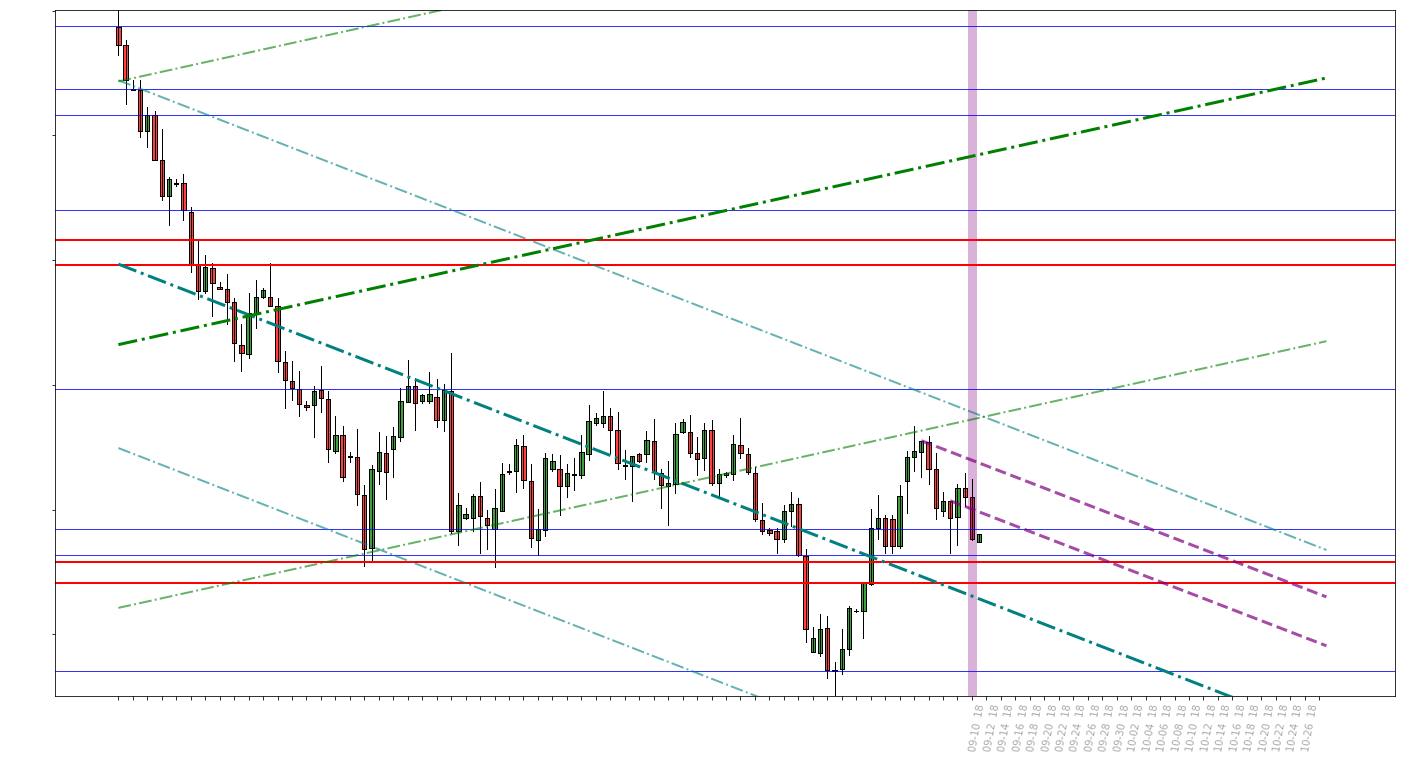

   2018-09-09 00h
Marubozu
Immediate Trend Direction: Downwards
In Excess Below Long-term Value
In Excess of Long-term Value Area, Trend-following


In [3]:
get_analyzed_plot('EUR_USD', '1', 'D', len_longterm=552, len_window=122)